In [1]:
#TODO: a model trained on 24x24 to 192x192, check its performance
#write dataset that receive one tile video at 192x192



In [2]:
# import os
# import json
# import random
import numpy as np
import torchvision as tv
import torch as t
import time
import imp

import lib
# import lib_train
# import networks
import datasets
import networks

# import imp
imp.reload(networks)
imp.reload(lib)
imp.reload(datasets)
# imp.reload(lib_train)


<module 'datasets' from '/home/anh2/workspace/tile-super-resolution/datasets.py'>

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline


In [4]:
img_h0 = 192
img_w0 = 192
scale_factor = .125

target_mean_list, target_std_list = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
toImage = lib.ToImage(target_mean_list, target_std_list)
toVideo = lib.ToVideo(target_mean_list, target_std_list)

#input image size
img_h, img_w = int(img_h0 * scale_factor), int(img_w0 * scale_factor)


refimg_h, refimg_w = img_h, img_w #for now, reference patch has the same low resolution ias input image

In [5]:
root = './datasets/tiles'
#root = './datasets/davis'

SAMPLE_LENGTH = 3
NUM_WORKER_TRAINLOADER = 12
NUM_WORKER_TESTLOADER  = 1
BATCH_SIZE_TRAIN = 1

frame_lr_transform    = tv.transforms.Compose([tv.transforms.Resize((img_h, img_w))])#480, 864
frame_hr_transform = tv.transforms.Compose([tv.transforms.Resize((img_h0, img_w0))])#480, 864
refframe_transform = tv.transforms.Compose([tv.transforms.Resize((refimg_h, refimg_w))])#tv.transforms.Compose([lib.Resize(refframe_scale_factor), lib.ToTensor(), lib.Normalize(target_mean_list, target_std_list)])#480, 864
#vid_transform   = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
vid_transform   = tv.transforms.Compose([lib.ToTensor(), lib.Normalize(target_mean_list, target_std_list)])
trainset = datasets.InpaintDataset(root, mode = datasets.InpaintDataset.MODE_TRAIN, sample_length=SAMPLE_LENGTH, \
                                  frame_lr_transform=frame_lr_transform, frame_hr_transform=frame_hr_transform, vid_transform=vid_transform)
trainloader = t.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=NUM_WORKER_TRAINLOADER)


# testset = datasets.InpaintDataset(root, mode = datasets.InpaintDataset.MODE_TEST, sample_length=SAMPLE_LENGTH, \
#                                   frame_lr_transform=frame_lr_transform, frame_hr_transform=frame_hr_transform, vid_transform=vid_transform, refframe_transform=refframe_transform)
# testloader = t.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=NUM_WORKER_TESTLOADER)

In [6]:
%%capture

sr_path = './models/sr_epoch{}'

ngpu = 2
device = t.device("cuda:0" if (t.cuda.is_available() and ngpu > 0) else "cpu")
#device = t.device('cpu')
#iG = Generator(128)
stack_num = 8
hidden=128
sr = networks.SuperRes(hidden=hidden, stack_num=stack_num)
#iG.load_state_dict(t.load('./models/iG_epoch10')) #for unit test purpose only
sr.to(device)


In [7]:
beta1 = .5
optim = t.optim.Adam(sr.parameters(), lr=2e-4)


In [8]:
t_train_begin = time.time()

criterion = t.nn.MSELoss()

def loss_to_psnr(mse):
    psnr = 10 * np.log10(1 / mse)
    return psnr

def cal_psnr(pred, gt):
    mse = criterion(pred, gt)
    return loss_to_psnr(mse)

def infer(model, input, measurement=False):
    if measurement == False:
        return {'pred': model(input)}
    else:
        t.cuda.synchronize()
        since = int(round(time.time()*1000))        
        pred = sr(input)
        t.cuda.synchronize()
        time_elapsed = int(round(time.time()*1000)) - since     
        return {'pred': pred, 'time_elapsed': time_elapsed}

def show_train_images(plt, pred, frame_lr, frame_hr):
    img1 = toImage(pred)
    plt.imshow(img1)
    plt.figure()
    img2 = toImage(frame_lr)
    plt.imshow(img2)
    plt.figure()
    img3 = toImage(frame_hr)
    plt.imshow(img3)
    cal_psnr(pred, frame_hr)
    plt.figure()
    
import os


log_loss = []
log_psnr = []

In [ ]:
btime = time.time()
for epoch in range(0, 20000):
    running_loss = 0.0
    running_psnr = 0.0
    for idx, ((frame_lr_list, frame_hr_list), frameidx_list) in enumerate(trainloader):
        #input frames has shape: BxTXCX
        frame_lr = frame_lr_list[:, 0, :, :, :].to(device)#only get the rist frame, not the whole video
        frame_hr = frame_hr_list[:, 0, :, :, :].to(device)
        
        optim.zero_grad()
        pred = infer(sr, frame_lr)['pred']
        loss = criterion(pred, frame_hr)
        loss.backward()
        optim.step()
        
        loss_item = loss.detach().item()
        running_loss += loss_item
        running_psnr += loss_to_psnr(loss_item)
    
        
        if (epoch * len(trainloader) + idx) % 100 == 99:    # print every 2000 mini-batches
            report_time = (time.time( )- btime) * 1000
            btime = time.time()
            print('[time: %d (ms), epoch: %d, iteration: %2d] loss: %.4f, psnr: %.4f' %
                  (report_time * 1000, epoch + 1, idx + 1, running_loss / 99, running_psnr / 99))
            running_loss = 0.0  
            running_psnr = 0.0
            log_psnr.append(loss_to_psnr(loss_item))
            log_loss.append(loss_item)
            
        if (epoch * len(trainloader) + idx) % 4000 == 3999:
            t.save(sr.state_dict(), sr_path.format(epoch))

[time: 22006700 (ms), epoch: 34, iteration:  1] loss: 0.0013, psnr: 0.0912
[time: 21374919 (ms), epoch: 67, iteration:  2] loss: 0.0008, psnr: 0.2799


In [ ]:
#t.save(sr.state_dict(), sr_path.format(epoch))

In [ ]:
plt.plot(log_loss)
plt.plot(log_psnr)

tensor(0.3804) tensor(-0.7804)
tensor(18.4072)
tensor(-0.0275) tensor(-0.8039)
tensor(19.0986)
tensor(0.0118) tensor(-0.7176)
tensor(14.8271)


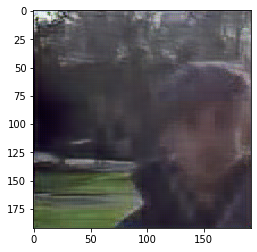

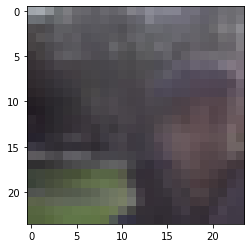

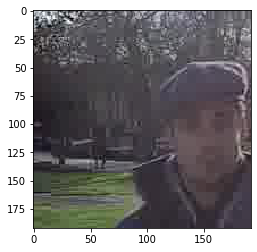

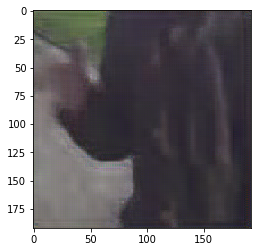

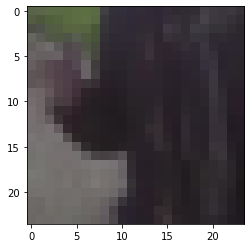

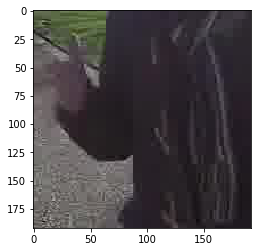

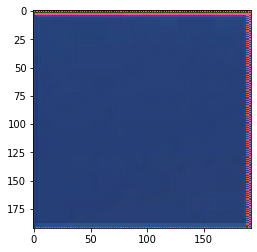

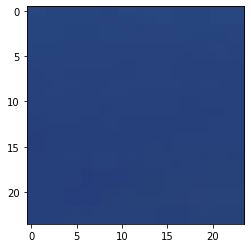

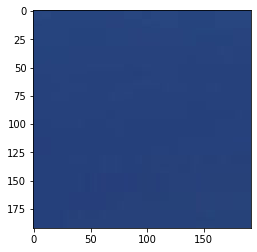

<Figure size 432x288 with 0 Axes>

In [11]:
for idx, ((frame_lr_list, frame_hr_list), frameidx_list) in enumerate(trainloader):
    frame_lr = frame_lr_list[:, 0, :, :, :].to(device)#only get the rist frame, not the whole video
    frame_hr = frame_hr_list[:, 0, :, :, :].to(device)   
    with t.no_grad():
        pred = infer(sr, frame_lr)['pred']
    
    print (frame_lr_list.max(), frame_lr_list.min())
    show_train_images(plt, pred[0].detach().cpu(), frame_lr_list[0][0].detach().cpu(), frame_hr_list[0][0].detach().cpu())
    print (cal_psnr(pred[0].detach().cpu(), frame_hr_list[0][0].detach().cpu()))

In [ ]:
infer(sr, frame_lr, measurement=True)['time_elapsed']

In [10]:
frame_lr.max(), frame_lr.min()


(tensor(-0.0039, device='cuda:0'), tensor(-0.7804, device='cuda:0'))

In [31]:
%debug

> /home/anh2/workspace/tile-super-resolution/lib.py(164)__call__()
    162         #x = (x - x.min())/(x.max() - x.min()) * 255
    163         x = x.type(t.IntTensor)
--> 164         x = x.numpy().transpose(1, 2, 0)
    165         return x
    166 

ipdb> x.shape
torch.Size([3, 3, 24, 24])
ipdb> q
